# Capstone Project: Unsupervised customers

# Context: 

Our client is an online retailer based in the UK. They sell 'all- occasion' gifts and many of their customers are wholesalers. Most of their customers are based in the UK, however, they do have a small percentage of customers from abroad. 

They would like to **segment these customers based on their previous purchase patterns**. Their goal is to provide more tailored services and enhance their marketing efforts towards international customers.

Currently, customers are grouped by **country of purchase** and this is not an optimal segmentation pattern because:

1) There are many countries, and hence, **many groups**

2) Some countries have a **negligible** number of customers in comparison to others 

3) 'Large' and 'Small' customers are treated the same way **regardless** of their purchase patterns 

The client would like us to help them by creating **3 clusters of customers** (a.k.a customer segments). To aid us in our task, we have past purchase data at the transaction level.


# Objective: 

Our task is to build a **clustering model** that factors in **aggregate sales patterns and specific items purchased by each customer**.

# Document Structure

There are **4 key steps** in the overarching Machine Learning framework that we will follow:

**Section 1** - Data Wrangling: This first step will involve us restructuring and manipulating our dataset in order to generate the features required for our clustering model

**Section 2** - Dimensionality Reduction: We will understand how to reduce the dimensionality of our dataset with multiple input features through feature elimination 

**Section 3** - Principal Component Analysis (PCA): We will explore how to reduce the dimensionality of our dataset with multiple input features through feature extraction  

**Section 4** - Cluster Analysis: We will develop clusters based on the analyses from the preceding section 

## Section 1: Data Wrangling

In this section, we will aggregate and restructure our dataset into a more useful and appropriate format for the task at hand. For example, the dataset that we have been provided with aggregates data at the **transaction level by specific item purchases**. 

However, as we would like to have the data at a **customer level** (since we are building clusters for customers), we need to aggregate the **transactions by customer** and further develop relevant customer- level features.

### Part 1A: Preliminary data cleaning

#### Let's import the relevant libraries

In [1]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns
sns.set_style('darkgrid')

#### Let's now read in and explore our dataset

In [2]:
# Load international online transactions data from the CSV file 
tx_df = pd.read_csv('int_online_tx.csv')

In [3]:
# Let's have a brief scan of the dataset 
tx_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France


From the above, we can see that the data provided is at the transaction level, i.e., purchase details are there for every single item and is **not aggregated** by either **customer** or by **cart**. In order to make the data more conducive to the task at hand (which is to segment customers by their purchase patterns), we will introduce these aggregations later on in the section. 

In [4]:
# Let's explore the column datatypes
tx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35116 entries, 0 to 35115
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    35116 non-null  int64  
 1   StockCode    35116 non-null  object 
 2   Description  35116 non-null  object 
 3   Quantity     35116 non-null  int64  
 4   InvoiceDate  35116 non-null  object 
 5   UnitPrice    35116 non-null  float64
 6   CustomerID   33698 non-null  float64
 7   Country      35116 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.1+ MB


The Dtype's for **most** of the features is as expected.

We should convert the Dtype for *'CustomerID'* from *float64* to *int64* as *'CustomerID'* should only take discrete values.

Further, there is currently no feature for *'Overall Sales per transaction'*, however we can engineer that feature through taking the product of the *Quantity* and *UnitPrice*.

Before we incorporate either of those edits, let's also check for any **null values** in our dataset.

In [5]:
# Check for null values
tx_df.isnull().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     1418
Country           0
dtype: int64

It would appear that there are 1418 *'CustomerID'* values that are null - **we should remove these values** as they will hinder of efforts in labeling a new customer segment. For example, if we were to aggregate our data whilst keeping the 'Missing' values, we would attribute all transactions to a single 'Missing' customer which is of no use.

#### Let's now remove null values, alter our CustomerID Dtypes and engineer a new feature for overall sales  

In [6]:
# Remove transactions with null Customer ID's 
clean_tx_df = tx_df[tx_df.CustomerID.notnull()].copy()

# Let's convert the CustomerID Dtypes from float values to to integers as they should only take discrete values
clean_tx_df['CustomerID'] = clean_tx_df.CustomerID.astype(int)

# Let's create a feature for Overall Sales per transaction 
clean_tx_df['Sales'] = clean_tx_df.Quantity * clean_tx_df.UnitPrice

### Part 1B: Feature engineering  

For the aggregation at the **customer level**, we may like to view the following:

- Number of transactions per customer
- Number of products purchased per customer
- Average order value per customer
- Total sales per customer
- Etc..

Let's begin by aggregating the **transaction data by customer**.

We will begin by calculating the total **number of unique transactions** by *'CustomerID'*

In [7]:
# Aggregate data by InvoiceNo (Number of purchases per customer)
invoice_data = clean_tx_df.groupby('CustomerID').InvoiceNo.agg(['nunique'])
# Name the column as total_transactions
invoice_data.columns = ['total_transactions']
invoice_data.head()

,total_transactions
CustomerID,
12347,7
12348,4
12349,1
12350,1
12352,8


Let's now aggregate **product data by customer**.

We will create 2 new features:

- *'total_products'* which will represent the total **number of products** purchased by each customer 
- *'total_unique_products'* which will represent the **number of unique products** purchased by each customer 

In [8]:
# Aggregate data by CustomerID per product
product_data = clean_tx_df.groupby('CustomerID').StockCode.agg(['count','nunique'])
product_data.columns = ['total_products','total_unique_products']
product_data.head()

,total_products,total_unique_products
CustomerID,,
12347,182,103
12348,31,22
12349,73,73
12350,17,17
12352,85,59


Finally, we are now in a position to aggregate **sales data by customer**. We will create 2 more features:

- *'total_sales'* - the total sales per customer
- *'avg_product_value'* - the average value of the products purchased per customer

In [9]:
# Aggregate sales per customer
sales_data = clean_tx_df.groupby('CustomerID').Sales.agg(['sum','mean'])
sales_data.columns = ['total_sales','avg_product_value']
sales_data.head()

,total_sales,avg_product_value
CustomerID,,
12347,4310.00,23.681319
12348,1797.24,57.975484
12349,1757.55,24.076027
12350,334.40,19.670588
12352,2506.04,29.482824


If we wanted to calculate the average cart/ invoice value for each customer then we need to create an intermediary table. 

For instance, *'avg_product_value'* does not provide us with this answer because it does not group products that were purchased within the same "cart".

To solve this problem, we can aggregate cart data at the "cart-level" and in order to do that, we need to group by both *'CustomerID'* and *'InvoiceID'*.

Next, we can calculate *'cart_value'* by taking the sum of the *Sales* column. This is the total sales by cart/ invoice.

In [10]:
# Aggregate cart- level data (i.e., Average order value per invoice)
cart_data = clean_tx_df.groupby(['CustomerID','InvoiceNo']).Sales.agg(['sum'])
cart_data.columns = ['cart_value']

# Reset index
cart_data.reset_index(inplace=True)

cart_data.head()

,CustomerID,InvoiceNo,cart_value
0,12347,537626,711.79
1,12347,542237,475.39
2,12347,549222,636.25
3,12347,556201,382.52
4,12347,562032,584.91


We now need to aggregate the cart- level data by *'CustomerID'* again to get customer-level cart data. Just before we do that, we can also engineer the following useful features:

- *'avg_cart_value'* - average cart value by customer.
- *'min_cart_value'* - minimum cart value by customer.
- *'max_cart_value'* - maximum cart value by customer.

In [11]:
# Aggregate cart- level data (average, min, max) per customer 
agg_cart_data = cart_data.groupby(['CustomerID']).cart_value.agg(['mean','min','max'])
agg_cart_data.columns = ['avg_cart_value','min_cart_value','max_cart_value']
agg_cart_data.head()

,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,
12347,615.714286,224.82,1294.32
12348,449.310000,227.44,892.80
12349,1757.550000,1757.55,1757.55
12350,334.400000,334.40,334.40
12352,313.255000,120.33,840.30


We now have four dataframes that each contain features at the customer-level :

- *invoice_data*
- *product_data*
- *sales_data*
- *agg_cart_data*

**We just need to join and merge all these dataframes together.**

In [12]:
# Join together the singular dataframes into one, aggregate dataframe (analytical base table)
customer_df = invoice_data.join([product_data, sales_data, agg_cart_data])
customer_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30


#### Great! We have now arrived at our analytical base table which we will feed into our algorithm

In [13]:
# Save analytical base table
customer_df.to_csv('analytical_base_table.csv')

## Section 2: Dimensionality Reduction

Our client would like our clustering model to take into account not only **how** much a customer purchases but also **what** they purchase. I.e., customers purchasing similar items should be grouped together in our clustering model.

We will now explore how this requirement can dramatically increase the number of features within our dataset and lead us to tackle the problem known as the **'Curse of Dimensionality'.**

#### Let us begin by reading in our dataset and examining how many unique products there are within our dataset

In [14]:
tx_df = pd.read_csv('cleaned_transactions.csv')

# Number of unique products
len(tx_df.StockCode.unique())

2574

We have 2574 unique products which is a very large number. We will now see why this will be problematic for us and to illustrate this point, let us consider transaction data at the customer level for two random '*CustomerID*': **14566** and **17844** 

In [15]:
# Toy dataset to consider the purchases of Customer IDs 14566 and 17844
toy_df = tx_df[tx_df.CustomerID.isin([14566,17844])]
toy_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
19250,563900,85099C,JUMBO BAG BAROQUE BLACK WHITE,200,8/21/11 11:05,1.79,14566,Channel Islands,358.00
19251,563900,85099B,JUMBO BAG RED RETROSPOT,200,8/21/11 11:05,1.79,14566,Channel Islands,358.00
19252,563900,23199,JUMBO BAG APPLES,200,8/21/11 11:05,1.79,14566,Channel Islands,358.00
19253,563900,22386,JUMBO BAG PINK POLKADOT,200,8/21/11 11:05,1.79,14566,Channel Islands,358.00
19851,564428,21993,FLORAL FOLK STATIONERY SET,12,8/25/11 11:27,1.25,17844,Canada,15.00
19852,564428,23295,SET OF 12 MINI LOAF BAKING CASES,8,8/25/11 11:27,0.83,17844,Canada,6.64
19853,564428,23293,SET OF 12 FAIRY CAKE BAKING CASES,16,8/25/11 11:27,0.83,17844,Canada,13.28
19854,564428,23296,SET OF 6 TEA TIME BAKING CASES,8,8/25/11 11:27,1.25,17844,Canada,10.00
19855,564428,23294,SET OF 6 SNACK LOAF BAKING CASES,8,8/25/11 11:27,0.83,17844,Canada,6.64


As we can see above, 9 different items have been purchased (4 by '*CustomerID*':14566 and 5 by '*CustomerID*':17844).

Rather than visually scanning through the table and counting the number of purchases, we can aggregate the information at a customer level. As we cannot input text variables into our algorithm, we need an alternative way of referring to the purchase of an item. We can achieve this through the use of **dummy variables**, with a value of: 

- 1 representing the purchase of an item 
- 0 representing that an item was not purchased

Below, we will create a dataframe showing the above with the columns holding the individual *'StockCode'* and the *'CustomerID'*.
(We do not require any of the other features and thus we can remove them for the purpose of this task).

In [16]:
# Get toy_item_dummies
toy_item_dummies = pd.get_dummies( toy_df.StockCode )

# Add CustomerID to toy_item_dummies
toy_item_dummies['CustomerID'] = toy_df.CustomerID

# Display toy_item_dummies
toy_item_dummies

,21993,22386,23199,23293,23294,23295,23296,85099B,85099C,CustomerID
19250,0,0,0,0,0,0,0,0,1,14566
19251,0,0,0,0,0,0,0,1,0,14566
19252,0,0,1,0,0,0,0,0,0,14566
19253,0,1,0,0,0,0,0,0,0,14566
19851,1,0,0,0,0,0,0,0,0,17844
19852,0,0,0,0,0,1,0,0,0,17844
19853,0,0,0,1,0,0,0,0,0,17844
19854,0,0,0,0,0,0,1,0,0,17844
19855,0,0,0,0,1,0,0,0,0,17844


We can now aggregate this information by *'CustomerID'*:

In [17]:
# Create toy_item_data by aggregating at customer level
toy_item_data = toy_item_dummies.groupby('CustomerID').sum()

# Display toy_item_data
toy_item_data

,21993,22386,23199,23293,23294,23295,23296,85099B,85099C
CustomerID,,,,,,,,,
14566,0,1,1,0,0,0,0,1,1
17844,1,0,0,1,1,1,1,0,0


We have successfully grouped the purchase of each item by '*CustomerID* and we can now extend this analysis to all of the remaining '*CustomerIDs*'

In [18]:
# Create dummy variables
item_dummies = pd.get_dummies(tx_df.StockCode)

# Add CustomerID into the item_dummies dataframe
item_dummies['CustomerID'] = tx_df.CustomerID

# Create item_data by aggregating at customer level
item_data = item_dummies.groupby('CustomerID').sum()

# Display first 5 rows of item_data
item_data.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85231B,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5


#### Let us now see the exact number of purchases for each item.

In [19]:
# Frequency of purchase for each item
item_data.sum()

10002       12
10120        1
10125       13
10133        5
10135        4
          ... 
90202D       1
90204        1
C2           6
M           34
POST      1055
Length: 2574, dtype: int64

As can be seen above, we have a dataset with thousands of features (2575 to be exact). This is significant as a dataset with this many features will encounter the problem known as the '**Curse of Dimensionality**'. 

Clustering algorithms attempt to form clusters through describing similarity between data points through the **Euclidean distance** between them. In high dimensional data, the distances appear to be approximately equal and thus all the observations appear equally alike (as well as equally different), and thus **no meaningful clusters can be formed**.

One simple way to reduce the dimensionality of this dataset is to through a process of **feature elimination** which we can achieve through setting a **threshold** for the number of features that we will keep.

#### Let's save this dataframe 

In [20]:
# Save item_data.csv
item_data.to_csv('item_data.csv')

### Part 2B: Thresholds

The underlying methodology of the thresholding approach is to keep only the **most popular** items within our dataset. The more popular a product is, the more **meaningful comparisons** we can create.

For the purposes of this task, we can keep the **20** most popular items.

**Let us now see the frequency of purchases for each of the items.**


In [21]:
# List of 20 most popular items (Observe the last 20 values (since they are sorted in ascending order by default))
item_data.sum().sort_values().tail(20)

22961      114
22630      115
22139      117
21080      122
85099B     123
20726      123
20719      128
20750      132
23084      140
20725      141
21212      143
22551      158
22629      160
22328      166
21731      169
22556      179
22554      197
22423      222
22326      271
POST      1055
dtype: int64

In [22]:
# List of corresponding StockCodes for each product 
top_20_items = item_data.sum().sort_values().tail(20).index
print(top_20_items)

Index(['22961', '22630', '22139', '21080', '85099B', '20726', '20719', '20750',
       '23084', '20725', '21212', '22551', '22629', '22328', '21731', '22556',
       '22554', '22423', '22326', 'POST'],
      dtype='object')


#### We will create a list with the features for those 20 items.

In [23]:
# Code to keep features for all the top 20 items
top_20_item_data = item_data[top_20_items]

# Check size and shape 
top_20_item_data.shape

(414, 20)

In [24]:
top_20_item_data.head()

,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


These 20 features are much more manageable than the 2574 that we had before. We will see another way to reduce dimensionality based on **'feature extraction'** in the next section.

#### Let's save this dataframe 

In [25]:
# Save dataset
top_20_item_data.to_csv('threshold_item_data.csv')

## Section 3: Principal Component Analysis (PCA)

In the previous section, we explored a method of dimensionality reduction through feature elimination. We will now explore an alternative method **(Principal Component Analysis)** which will focus upon achieving dimensionality reduction through feature extraction.

Principal Component Analysis allows us to combine our input features in a manner which will allow us to remove the “least important” variables while still retaining the most valuable parts of all of the variables.

### Part 3A: Item Data PCA

#### Let's import relevant packages for this section

In [26]:
# StandardScaler from Scikit-Learn
from sklearn.preprocessing import StandardScaler

# PCA from Scikit-Learn
from sklearn.decomposition import PCA

One of key assumptions for PCA is that our features should all be on the **same scale**, hence we will now **standardize** our features.

In [27]:
# Initialising StandardScaler
scaler = StandardScaler()

# Transforming the item data
item_data_scaled = scaler.fit_transform(item_data)

# Display first five rows
print(item_data_scaled[:5])

[[-0.13303802 -0.04920678 -0.1119152  ... -0.10482848 -0.15568183
  -0.68068072]
 [-0.13303802 -0.04920678 -0.1119152  ... -0.10482848 -0.15568183
   0.38776219]
 [-0.13303802 -0.04920678 -0.1119152  ... -0.10482848 -0.15568183
  -0.41356999]
 [-0.13303802 -0.04920678 -0.1119152  ... -0.10482848 -0.15568183
  -0.41356999]
 [-0.13303802 -0.04920678 -0.1119152  ... -0.10482848  5.53128397
   0.65487292]]


#### Let's generate the principal component features from item_data_scaled

In [28]:
# Initialize and fit a PCA transformation
pca = PCA()
pca.fit(item_data_scaled)

PCA()

In [29]:
# Generate the Principal component features
PC_items = pca.transform(item_data_scaled)                         
# Display first five rows
print(PC_items[:5])

[[ 5.87614052e+00  4.82891689e+00 -4.95545069e-01 ... -6.62646278e-04
  -4.43629806e-05  7.13318293e-15]
 [-4.21983747e+00  1.22621722e+00 -1.88191211e+00 ... -2.11471782e-04
  -2.69154340e-04 -3.07197844e-15]
 [-1.26084676e+00  2.38766371e+00 -7.31483440e-02 ...  2.57750179e-04
  -2.05682324e-04  3.08986777e-15]
 [-4.92931983e+00 -7.14858724e-01 -1.58093026e+00 ... -1.98603886e-03
   9.92316312e-05  2.70096445e-15]
 [-2.05311348e+00  2.11095022e+00  1.84807021e-01 ... -3.43415269e-04
  -1.32981672e-04  1.70696790e-15]]


Once fitted, the pca instance now contains the principal components for our dataset.

Principal components are a **set of vectors** where each vector represents the **direction of a line that best fits** the data whilst being **orthogonal** to the remaining principal components. The best fit line is defined as being one which **minimizes the average squared distance** from the points to the line. These directions constitute an orthonormal basis in which different individual dimensions of the data are linearly uncorrelated. We can use these components to perform a **change of basis** on the data.

Essentially, the principal components are a **linear combination** of our original features and each component in the sequence is along the direction that captures **the most variance**.

The above will become much clearer with the examples below.


### Part 3B: Explained variance

We can achieve dimensionality reduction through **keeping only** the principal components which explain the **greatest amount of variation** in the data and removing the others.

As a reminder, the principal components are a sequence of vectors in which vector accounts for the greatest variance after accounting for the ones preceding it.

We can now observe how much of the variance has been explained by each principal component and in order to do so, we can plot a graph showing the cumulative explained variance of each of the components.

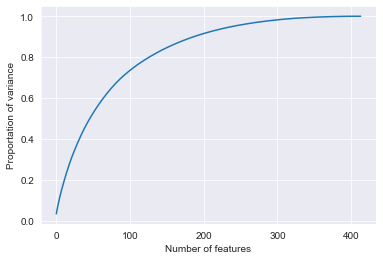

In [30]:
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)
plt.xlabel('Number of features')
plt.ylabel('Proportation of variance')
plt.show()

As expected, the greater the number of features which we hold onto, the greater the level of variance which is explained. We should look to keep a certain amount of features which would allow us to explain as much of the data as possible whilst achieving dimensionality reduction. From the plot, it would appear as if though with 125 features, we will be able to explain **~ 80% of the variation of the data which is ideal**.

In [31]:
print( cumulative_explained_variance[124] )

0.7955069032205403


### Part 3C: Dimensionality Reduction With PCA


#### Initialize and fit new PCA transformation with only 125 components

In [32]:
#Initialize the PCA transformation, keeping only 125 components
pca = PCA(n_components= 125)

# Fit and transform item_data_scaled
PC_items = pca.fit_transform(item_data_scaled)

# Display the shape of PCA items (check shape)
PC_items.shape

(414, 125)

We will create a new dataframe and label the columns PC1, PC2, PC3 etc to represent the principal components

In [33]:
# Place PC_items into a dataframe
items_pca = pd.DataFrame(PC_items)

# Format the name the columns
items_pca.columns = ['PC{}'.format(i + 1) for i in range(PC_items.shape[1])]

# Update its index
items_pca.index = item_data.index

# Display first 5 rows
items_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,...,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,5.876142,4.828942,-0.495518,3.093831,-0.633740,-11.534173,2.161897,7.116976,5.336121,4.424411,4.637029,2.316628,12.310897,1.986734,-11.431250,5.617988,-2.177529,7.665889,-12.136486,-16.048773,-5.949305,7.814550,40.518986,-35.575605,-17.558091,6.870936,20.887640,2.299606,-26.159633,-32.580389,7.882671,12.357700,6.825302,-32.957945,-4.405632,-17.238639,-11.278731,-14.485971,-2.761541,4.734511,-6.985842,-1.463279,10.602138,1.240572,3.087381,5.343040,-0.417662,1.648901,-6.371200,3.065884,...,2.354146,2.562952,-0.681927,-1.809008,-1.917099,1.264270,0.571087,-1.331671,-2.062200,-3.485349,0.188114,-1.929122,0.780955,0.146726,0.952714,-1.847177,0.964875,0.106935,-0.377966,0.835607,-0.372949,-0.431727,0.010923,-0.082284,0.164531,-0.565437,-1.111000,-1.345280,-0.325863,-0.406423,-0.803456,0.260760,0.809744,0.421674,1.344950,-0.325835,0.196683,0.510191,-0.004525,-0.297481,-0.288171,-0.772947,0.901042,0.085110,0.000452,-0.095417,0.258939,0.169182,0.166337,-0.033951
12348,-4.219841,1.226199,-1.881939,-0.174146,0.818275,1.160979,-0.871632,-0.846666,0.460602,0.854210,-0.402093,0.981697,-1.104893,0.769782,-0.093319,-0.312293,-0.448311,1.207592,0.383156,-0.470267,0.185100,0.055603,0.502170,0.374571,1.227238,-0.774974,-0.270532,0.849334,-0.369547,-0.573138,1.009516,-0.582039,0.948223,-0.735562,0.356327,-0.391793,-0.296461,0.392887,0.152131,0.329251,-0.469561,0.707069,1.202573,-0.199576,-0.873429,-0.061061,-0.424099,-1.628009,-0.411592,0.444909,...,-1.094228,-0.794194,-0.429598,-0.409380,0.031015,0.166243,-0.763463,-0.403439,0.809366,0.146578,0.183575,0.073429,-1.954424,0.357811,-0.177076,-0.908275,0.566534,0.872581,-0.509038,1.285449,-0.212533,0.331577,1.440810,-1.484870,-0.692340,0.246698,1.588148,0.081842,1.056207,0.066373,-2.314440,-0.926511,-0.770139,0.347371,-0.388460,0.232813,-1.225824,-0.194007,0.169278,0.954161,-0.028469,-1.768907,-0.934289,-1.618676,-0.474749,0.240724,-0.175090,-1.071840,-1.480333,-0.850379
12349,-1.260836,2.387626,-0.073145,-1.119083,-0.034572,-3.715360,-0.343833,-0.148444,-0.789810,-0.379984,1.570351,0.183830,0.223129,-0.052678,3.180370,-0.511218,-1.838414,0.383177,0.316105,-0.002675,-0.417078,0.454687,-0.792514,1.750363,-1.479961,0.758651,-0.919816,0.771110,0.498083,-1.340402,0.284873,0.672499,0.074235,-0.216324,-0.673288,-1.534838,0.786253,-1.429859,-0.096379,-0.929022,0.108108,-0.083437,-0.164403,0.690339,1.361978,-0.222485,-0.123774,-0.200008,0.876489,1.681097,...,2.190821,-0.875306,1.635939,0.413690,1.141083,-0.060143,-1.009700,0.989091,0.981714,-0.714741,1.523608,0.835243,-3.455854,-2.216327,0.608560,-2.236401,-1.528935,-1.930118,-0.840101,-2.521065,-0.162416,-0.592630,1.280459,-0.341826,1.936090,-0.997750,1.941794,0.726655,-2.220783,-0.329450,-2.461170,-1.346434,1.337305,-2.153318,-1.233963,0.053895,0.178845,-2.039532,0.517261,-0.935265,1.099822,2.604499,6.635139,3.985658,3.321292,2.851459,-1.019093,-1.104972,5.525030,0.797080
12350,-4.929318,-0.714872,-1.580944,-0.469859,-0.116365,0.647705,0.112899,-1.336288,1.546853,-1.190450,-0.213091,1.056776,-0.474770,0.856744,-1.306191,0.242938,0.268116,1.951801,-0.228358,0.570040,-0.187179,0.902664,1.364495,0.178227,-0.259952,-0.168623,-0.679140,1.083233,-0.156307,-0.398649,0.241983,0.632442,-1.445470,-0.185272,-0.315512,-0.305027,-1.356940,-0.002125,0.578865,-0.245934,0.586419,-0.217963,0.289679,0.527743,-0.530292,-0.097909,-1.481279,0.14038

We have now created a dataframe consisting of the 125 principal components which explain roughly 80% of the variation of the original dataset. We will now feed this dataframe into our clustering model in Section 4.

#### Let's save this dataframe 

In [34]:
# Save pca_item_data.csv
items_pca.to_csv('pca_item_data.csv')

## Section  4: K- Means Clustering

The K- means algorithm learns clusters based on the Euclidean distance between datapoints. It follows then, that our model will be influenced by the input features which we will provide and the distances between them.

In the previous sections, we have created three different dataframes, and we will now feed each of them into our clustering model and compare the performance of our model across each of them.

The datasets which we will be comparing are:

1) **Only** purchase pattern features - (created in Section 1 as *base_df.*)

2) Purchase pattern features + item features chosen by thresholding - This will be an **amalgamation of *base_df.* and  *threshold_item_data.***

3) Purchase pattern features + principal component features from items - This will be an **amalgamation *base_df.* and *pca_item_data.***

Once we have formed our clusters for each of the dataframes under consideration, we will then compare the performance of each clustering against one another. We will do this through using the **'Adjusted Rand Index'.** 

The 'Adjusted Rand Index' is a similarity measure between two clusterings and it works through comparing the observations that were assigned to the same or different clusters between two competing clusterings. It returns a score between 0.0-1.0 and values close to: 

- 0.0 indicate random/independent clusters
- 1.0 indicate nearly identical clusters

### Part 4A: Feature Sets

#### Let's import the relevant libraries 

In [35]:
# Scikit-Learn's make_pipeline function
from sklearn.pipeline import make_pipeline
### Part 4A: Feature Sets
# Scikit-Learn's KMeans algorithm
from sklearn.cluster import KMeans

#### Let's read in the relevant files

In [36]:
# Initialising index_col=0 for each dataframe will allow us to use CustomerID as the index.

# Import analytical base table
base_df = pd.read_csv('analytical_base_table.csv', index_col=0)

# Import thresholded item features
threshold_item_data = pd.read_csv('threshold_item_data.csv', index_col=0)

# Import PCA item features
pca_item_data = pd.read_csv('pca_item_data.csv', index_col=0)

#### Let's create the feature sets

In [37]:
# First 5 observations of base_df
base_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30


In [38]:
# Join base_df with threshold_item_data
threshold_df = base_df.join(threshold_item_data)

# Display first 5 rows of threshold_df
threshold_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


In [39]:
# Join base_df with pca_item_data
pca_df = base_df.join(pca_item_data)

# Display first 5 rows of pca_df
pca_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,...,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,5.876142,4.828942,-0.495518,3.093831,-0.633740,-11.534173,2.161897,7.116976,5.336121,4.424411,4.637029,2.316628,12.310897,1.986734,-11.431250,5.617988,-2.177529,7.665889,-12.136486,-16.048773,-5.949305,7.814550,40.518986,-35.575605,-17.558091,6.870936,20.887640,2.299606,-26.159633,-32.580389,7.882671,12.357700,6.825302,-32.957945,-4.405632,-17.238639,-11.278731,-14.485971,-2.761541,4.734511,-6.985842,-1.463279,...,2.354146,2.562952,-0.681927,-1.809008,-1.917099,1.264270,0.571087,-1.331671,-2.062200,-3.485349,0.188114,-1.929122,0.780955,0.146726,0.952714,-1.847177,0.964875,0.106935,-0.377966,0.835607,-0.372949,-0.431727,0.010923,-0.082284,0.164531,-0.565437,-1.111000,-1.345280,-0.325863,-0.406423,-0.803456,0.260760,0.809744,0.421674,1.344950,-0.325835,0.196683,0.510191,-0.004525,-0.297481,-0.288171,-0.772947,0.901042,0.085110,0.000452,-0.095417,0.258939,0.169182,0.166337,-0.033951
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,-4.219841,1.226199,-1.881939,-0.174146,0.818275,1.160979,-0.871632,-0.846666,0.460602,0.854210,-0.402093,0.981697,-1.104893,0.769782,-0.093319,-0.312293,-0.448311,1.207592,0.383156,-0.470267,0.185100,0.055603,0.502170,0.374571,1.227238,-0.774974,-0.270532,0.849334,-0.369547,-0.573138,1.009516,-0.582039,0.948223,-0.735562,0.356327,-0.391793,-0.296461,0.392887,0.152131,0.329251,-0.469561,0.707069,...,-1.094228,-0.794194,-0.429598,-0.409380,0.031015,0.166243,-0.763463,-0.403439,0.809366,0.146578,0.183575,0.073429,-1.954424,0.357811,-0.177076,-0.908275,0.566534,0.872581,-0.509038,1.285449,-0.212533,0.331577,1.440810,-1.484870,-0.692340,0.246698,1.588148,0.081842,1.056207,0.066373,-2.314440,-0.926511,-0.770139,0.347371,-0.388460,0.232813,-1.225824,-0.194007,0.169278,0.954161,-0.028469,-1.768907,-0.934289,-1.618676,-0.474749,0.240724,-0.175090,-1.071840,-1.480333,-0.850379
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,-1.260836,2.387626,-0.073145,-1.119083,-0.034572,-3.715360,-0.343833,-0.148444,-0.789810,-0.379984,1.570351,0.183830,0.223129,-0.052678,3.180370,-0.511218,-1.838414,0.383177,0.316105,-0.002675,-0.417078,0.454687,-0.792514,1.750363,-1.479961,0.758651,-0.919816,0.771110,0.498083,-1.340402,0.284873,0.672499,0.074235,-0.216324,-0.673288,-1.534838,0.786253,-1.429859,-0.096379,-0.929022,0.108108,-0.083437,...,2.190821,-0.875306,1.635939,0.413690,1.141083,-0.060143,-1.009700,0.989091,0.981714,-0.714741,1.523608,0.835243,-3.455854,-2.216327,0.608560,-2.236401,-1.528935,-1.930118,-0.840101,-2.521065,-0.162416,-0.592630,1.280459,-0.341826,1.936090,-0.997750,1.941794,0.726655,-2.220783,-0.329450,-2.461170,-1.346434,1.337305,-2.153318,-1.233963,0.053895,0.178845,-2.039532,0.517261,-0.935265,1.099822,2.604499,6.635139,3.985658,3.321292,2.851459,-1.019093,-1.104972,5.525030,0.797080
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,-4.929318,-0.714872,-1.580944,-0.469859,-0.116365,0.647705,0.112899,-1.336288,1.546853,-1.190450,-0.213091,1.056776,-0.474770,0.856744,-1.306191,0.242938,0.268116,1.951801,-0.228358,0.570040,-0.187179,0.902664,1.364495,0.178227,-0.259952,-0.168623,-0.679140,1.083233,-0.156307,-0.398649,0.241983,0.632442,-1.445470,-0.185272,-0.315512,-0.305027,-1.356940,-0.002125,0.578865,-0.245934,0.5

### Part 4B: Base DF Clustering

Before we begin creating the clusters for each of the feature sets we have, we should create a model pipeline. 
Collectively, the linear sequence of steps required to prepare the data, tune the model, and transform the predictions is called the **modeling pipeline**. As K-Means formulates clusters based on the Euclidean distance between points, we should begin by **standardizing** each of our features and we will include this step with our pipeline.

In [40]:
# K-Means model pipeline with 3 clusters 
k_means = make_pipeline(StandardScaler(),
                        KMeans(n_clusters=3, random_state=123))


In [41]:
# Fit K-Means pipeline
k_means.fit(base_df)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=123))])

We need to call the *.predict()* function to obtain our clusters

In [42]:
# Save clusters to base_df
base_df['cluster'] = k_means.predict(base_df)

# Display first 5 rows of base_df
base_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,cluster
CustomerID,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,1
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,0
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,0
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,0
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,0


Let's plot a scatterplot of the *total_sales* vs the *avg_cart_value* features. (We cannot plot for all features, so we have chosen only 2).

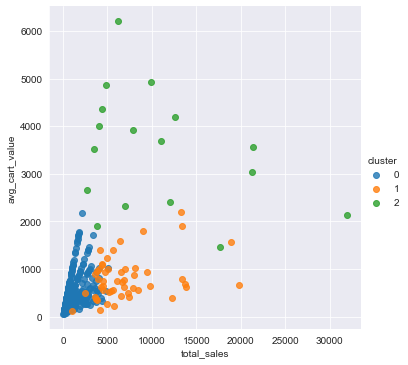

In [43]:
# Scatterplot, coloured by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster',
           data=base_df, fit_reg=False)
plt.show()

### Part 4C: Threshold DF Clustering

We'll repeat the same steps as above for our second dataframe, *threshold_df*.

In [44]:
# K-Means model pipeline
k_means = make_pipeline(StandardScaler(),
                        KMeans(n_clusters=3, random_state=123))
# Fit K-Means pipeline
k_means.fit(threshold_df)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=123))])

In [45]:
# Save clusters to threshold_df
threshold_df['cluster'] = k_means.predict(threshold_df)

# Display first 5 rows of threshold_df
threshold_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST,cluster
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0,0
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5,2


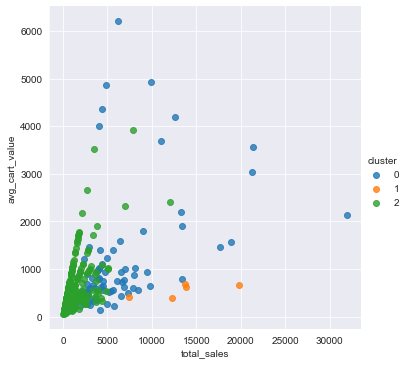

In [46]:
# Scatterplot, coloured by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster',
           data=threshold_df, fit_reg=False)
plt.show()

### Part 4D: PCA DF Clustering

We'll repeat the same steps as above for our third, and last dataframe, *pca_df*.

In [47]:
# K-Means model pipeline
k_means = make_pipeline(StandardScaler(),
                        KMeans(n_clusters=3, random_state=123))

In [48]:
# Fit K-Means pipeline
k_means.fit(pca_df)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=123))])

In [49]:
# Save clusters to pca_df
pca_df['cluster'] = k_means.predict(pca_df)

# Display first 5 rows of pca_df
pca_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,...,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,cluster
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,5.876142,4.828942,-0.495518,3.093831,-0.633740,-11.534173,2.161897,7.116976,5.336121,4.424411,4.637029,2.316628,12.310897,1.986734,-11.431250,5.617988,-2.177529,7.665889,-12.136486,-16.048773,-5.949305,7.814550,40.518986,-35.575605,-17.558091,6.870936,20.887640,2.299606,-26.159633,-32.580389,7.882671,12.357700,6.825302,-32.957945,-4.405632,-17.238639,-11.278731,-14.485971,-2.761541,4.734511,-6.985842,-1.463279,...,2.562952,-0.681927,-1.809008,-1.917099,1.264270,0.571087,-1.331671,-2.062200,-3.485349,0.188114,-1.929122,0.780955,0.146726,0.952714,-1.847177,0.964875,0.106935,-0.377966,0.835607,-0.372949,-0.431727,0.010923,-0.082284,0.164531,-0.565437,-1.111000,-1.345280,-0.325863,-0.406423,-0.803456,0.260760,0.809744,0.421674,1.344950,-0.325835,0.196683,0.510191,-0.004525,-0.297481,-0.288171,-0.772947,0.901042,0.085110,0.000452,-0.095417,0.258939,0.169182,0.166337,-0.033951,0
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,-4.219841,1.226199,-1.881939,-0.174146,0.818275,1.160979,-0.871632,-0.846666,0.460602,0.854210,-0.402093,0.981697,-1.104893,0.769782,-0.093319,-0.312293,-0.448311,1.207592,0.383156,-0.470267,0.185100,0.055603,0.502170,0.374571,1.227238,-0.774974,-0.270532,0.849334,-0.369547,-0.573138,1.009516,-0.582039,0.948223,-0.735562,0.356327,-0.391793,-0.296461,0.392887,0.152131,0.329251,-0.469561,0.707069,...,-0.794194,-0.429598,-0.409380,0.031015,0.166243,-0.763463,-0.403439,0.809366,0.146578,0.183575,0.073429,-1.954424,0.357811,-0.177076,-0.908275,0.566534,0.872581,-0.509038,1.285449,-0.212533,0.331577,1.440810,-1.484870,-0.692340,0.246698,1.588148,0.081842,1.056207,0.066373,-2.314440,-0.926511,-0.770139,0.347371,-0.388460,0.232813,-1.225824,-0.194007,0.169278,0.954161,-0.028469,-1.768907,-0.934289,-1.618676,-0.474749,0.240724,-0.175090,-1.071840,-1.480333,-0.850379,0
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,-1.260836,2.387626,-0.073145,-1.119083,-0.034572,-3.715360,-0.343833,-0.148444,-0.789810,-0.379984,1.570351,0.183830,0.223129,-0.052678,3.180370,-0.511218,-1.838414,0.383177,0.316105,-0.002675,-0.417078,0.454687,-0.792514,1.750363,-1.479961,0.758651,-0.919816,0.771110,0.498083,-1.340402,0.284873,0.672499,0.074235,-0.216324,-0.673288,-1.534838,0.786253,-1.429859,-0.096379,-0.929022,0.108108,-0.083437,...,-0.875306,1.635939,0.413690,1.141083,-0.060143,-1.009700,0.989091,0.981714,-0.714741,1.523608,0.835243,-3.455854,-2.216327,0.608560,-2.236401,-1.528935,-1.930118,-0.840101,-2.521065,-0.162416,-0.592630,1.280459,-0.341826,1.936090,-0.997750,1.941794,0.726655,-2.220783,-0.329450,-2.461170,-1.346434,1.337305,-2.153318,-1.233963,0.053895,0.178845,-2.039532,0.517261,-0.935265,1.099822,2.604499,6.635139,3.985658,3.321292,2.851459,-1.019093,-1.104972,5.525030,0.797080,0
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,-4.929318,-0.714872,-1.580944,-0.469859,-0.116365,0.647705,0.112899,-1.336288,1.546853,-1.190450,-0.213091,1.056776,-0.474770,0.856744,-1.306191,0.242938,0.268116,1.951801,-0.228358,0.570040,-0.187179,0.902664,1.364495,0.178227,-0.259952,-0.168623,-0.679140,1.083233,-0.156307,-0.398649,0.241983,0.632442,-1.445470,-0.185272,-0.315512,-0.305027,-1.356940,-0.002125,0.578865,-0.245934,0.586419,-0.217963,...

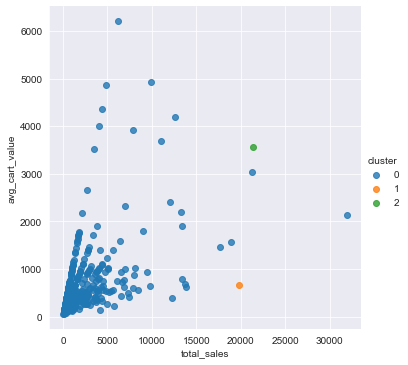

In [50]:
# Scatterplot, coloured by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster',
           data=pca_df, fit_reg=False)
plt.show()

### Part 4E: Model "Comparison"

As each of our three dataframes share the same *CustomerID*, it is straightforward to compare and contrast the performance of our clustering model across the dataframes. 

As a brief reminder, the clusters under consideration are those created by:

- Purchase pattern features exclusively (*base_df*)
- Purchase pattern features and thresholded item data (*threshold_df*)
- Purchase pattern features and PCA item data (*pca_df*)

Unlike in supervised learning tasks where we have a 'ground truth' against which we can directly judge model performance, for clustering algorithms, there are no widely- accepted performance metrics for scoring model  performance as we ourselves do not know what is 'true'. Hence, it is best to compare the clusters created by competing approaches. As mentioned earlier, we will compare the clusters through the 'Adjusted Rand Index'.

In [51]:
# Adjusted Rand index
from sklearn.metrics import adjusted_rand_score

#### Adjusted Rand index between *base_df.cluster* and *threshold_df.cluster*

In [52]:
# Adjusted Rand Index between base_df.cluster and threshold_df.cluster
adjusted_rand_score(base_df.cluster, threshold_df.cluster)

0.6021354951782343

#### Adjusted Rand index between *base_df.cluster* and *pca_df.cluster*

In [53]:
# Adjusted Rand Index between base_df.cluster and pca_df.cluster
adjusted_rand_score(base_df.cluster, pca_df.cluster)

0.04231130774430798

#### Adjusted Rand index between *threshold_df.cluster* and *pca_df.cluster*

In [54]:
# Adjusted Rand Index between threshold_df.cluster and pca_df.cluster
adjusted_rand_score(threshold_df.cluster, pca_df.cluster)

0.03322042203231371

We have now finished our analysis. We have created three separate clusters using differing feature sets. Our task  now would be to showcase our findings to the client and to request their feedback. Thereafter, the client may accept one of the clusters which we have formed or else we may have to iterate according to the client's wishes.